In [1]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Apr 29 13:16:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 27%   28C    P8     5W / 250W |   1276MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1C:00.0 Off |                  N/A |
| 27%   

True

In [2]:
torch.cuda.get_device_name(device=0)

'GeForce RTX 2080 Ti'

In [3]:
torch.cuda.init()

In [4]:
import pickle
import numpy as np
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch.nn as nn
from matplotlib import colors, pyplot as plt
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

%matplotlib inline

In [5]:
# разные режимы датасета
DATA_MODES = ['train_hard_corrupted', 
              'val_hard_corrupted',
              'test_hard_corrupted',
             'train_medium_corrupted', 
              'val_medium_corrupted',
              'test_medium_corrupted',
             'train_light_corrupted', 
              'val_light_corrupted',
              'test_light_corrupted',
            'train_not_corrupted', 
              'val_not_corrupted',
              'test_not_corrupted']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [6]:
class DogsDataset(Dataset):
  def __init__(self, files, mode):
    super().__init__()
    # список файлов для загрузки
    self.files = sorted(files)
    # режим работы
    self.mode = mode
    if self.mode not in DATA_MODES:
      print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
      raise NameError
    self.len_ = len(self.files)

    self.label_encoder = LabelEncoder()
    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)
      with open('label_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(self.label_encoder, le_dump_file)

  def __len__(self):
      return self.len_

  def load_sample(self, file):
      image = Image.open(file)
      image.load()
      return image
  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)
  def __getitem__(self, index):
    hard_corrupted = transforms.Compose([
          transforms.ToTensor(),
          transforms.ToPILImage(),
          transforms.GaussianBlur(kernel_size=9),
          transforms.RandomGrayscale(0.3),
          transforms.RandomHorizontalFlip(),
          transforms.ColorJitter(0.1,0.1,0.1,0.1),
          transforms.RandomPerspective(),
          transforms.RandomInvert(p=0.3),
          transforms.ToTensor(),
          transforms.RandomErasing(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 
    medium_corrupted = transforms.Compose([
          transforms.ToTensor(),
          transforms.ToPILImage(),
          transforms.RandomPerspective(),
          transforms.ColorJitter(0.1,0.1,0.1,0.1),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.RandomErasing(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    light_corrupted = transforms.Compose([
          transforms.ToTensor(),
          transforms.ToPILImage(),
          transforms.ColorJitter(0.1,0.1,0.1,0.1),
          transforms.RandomHorizontalFlip(),
          transforms.RandomPerspective(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    transform_not_corrupted = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    x = np.array(x / 255, dtype='float32')
    if self.mode in ['test']:
        return transform_test(x) #тестовую не меняем
    else:
        if self.mode in ['train_not_corrupted', 'val_not_corrupted', 'test_not_corrupted']:
          x= transform_not_corrupted(x)
        elif self.mode in ['train_light_corrupted', 'val_light_corrupted', 'test_light_corrupted']:
          x=light_corrupted(x)
        elif self.mode in ['train_medium_corrupted', 'val_medium_corrupted','test_medium_corrupted']:
          x=medium_corrupted(x)
        elif self.mode in ['train_hard_corrupted', 'val_hard_corrupted', 'test_hard_corrupted']:
          x=hard_corrupted(x)
        
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y


In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
 inp = inp.numpy().transpose((1, 2, 0))
 mean = np.array([0.485, 0.456, 0.406])
 std = np.array([0.229, 0.224, 0.225])
 inp = std * inp + mean
 inp = np.clip(inp, 0, 1)
 plt_ax.imshow(inp)
 if title is not None:
   plt_ax.set_title(title)
 plt_ax.grid(False)

In [8]:
TRAIN_DIR = Path('train')
TEST_DIR = Path('test')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))

In [9]:
from sklearn.model_selection import train_test_split
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
 stratify=train_val_labels)

In [10]:
val_labels = [path.parent.name for path in val_files]
val_files, test_files = train_test_split(val_files, test_size=0.65, \
 stratify=val_labels)

In [11]:
len(train_files)

5374

In [12]:
len(val_files)

627

In [13]:
len(test_files)

1165

Создание датасетов разной степени испорченности

In [14]:
val_dataset_hard_corrupted = DogsDataset(val_files, mode='val_hard_corrupted')

In [15]:
test_dataset_hard_corrupted = DogsDataset(test_files, mode='test_hard_corrupted')

In [16]:
train_dataset_hard_corrupted = DogsDataset(train_files, mode='train_hard_corrupted')

In [17]:
!rm -rf test_hard_corrupted

In [18]:
!mkdir test_hard_corrupted

In [19]:
import os
for i in range(len(test_dataset_hard_corrupted)):
    direct = "test_hard_corrupted/" + str(test_dataset_hard_corrupted[i][1])
    if not os.path.exists(direct):
        os.mkdir(direct)
    name = direct + "/" + str(i) + ".jpeg"
    save_image(test_dataset_hard_corrupted[i][0], name)

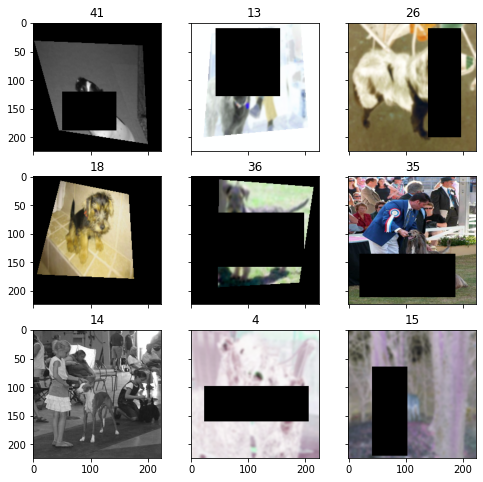

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
 random_characters = int(np.random.uniform(0,500))
 im_val, label = val_dataset_hard_corrupted[random_characters]
 img_label = " ".join(map(lambda x: x.capitalize(),\
 val_dataset_hard_corrupted.label_encoder.inverse_transform([label])[0].split('_')))
 imshow(im_val.data.cpu(), \
 title=img_label,plt_ax=fig_x)

In [17]:
val_dataset_medium_corrupted = DogsDataset(val_files, mode='val_medium_corrupted')

In [18]:
test_dataset_medium_corrupted = DogsDataset(test_files, mode='test_medium_corrupted')

In [19]:
train_dataset_medium_corrupted = DogsDataset(train_files, mode='train_medium_corrupted')

In [191]:
!rm -rf test_medium_corrupted

In [192]:
!mkdir test_medium_corrupted

In [193]:
for i in range(len(test_dataset_medium_corrupted)):
    direct = "test_medium_corrupted/" + str(test_dataset_medium_corrupted[i][1])
    if not os.path.exists(direct):
        os.mkdir(direct)
    name = direct + "/" + str(i) + ".jpeg"
    save_image(test_dataset_medium_corrupted[i][0], name)

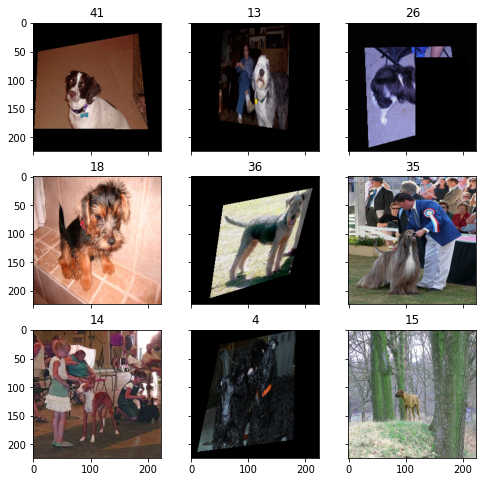

In [195]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
 random_characters = int(np.random.uniform(0,500))
 im_val, label = val_dataset_medium_corrupted[random_characters]
 img_label = " ".join(map(lambda x: x.capitalize(),\
 val_dataset_medium_corrupted.label_encoder.inverse_transform([label])[0].split('_')))
 imshow(im_val.data.cpu(), \
 title=img_label,plt_ax=fig_x)

In [45]:
val_dataset_light_corrupted = DogsDataset(val_files, mode='val_light_corrupted')

In [46]:
test_dataset_light_corrupted = DogsDataset(test_files, mode='test_light_corrupted')

In [47]:
train_dataset_light_corrupted = DogsDataset(train_files, mode='train_light_corrupted')

In [199]:
!rm -rf test_light_corrupted

In [200]:
!mkdir test_light_corrupted

In [201]:
for i in range(len(test_dataset_light_corrupted)):
    direct = "test_light_corrupted/" + str(test_dataset_light_corrupted[i][1])
    if not os.path.exists(direct):
        os.mkdir(direct)
    name = direct + "/" + str(i) + ".jpeg"
    save_image(test_dataset_light_corrupted[i][0], name)

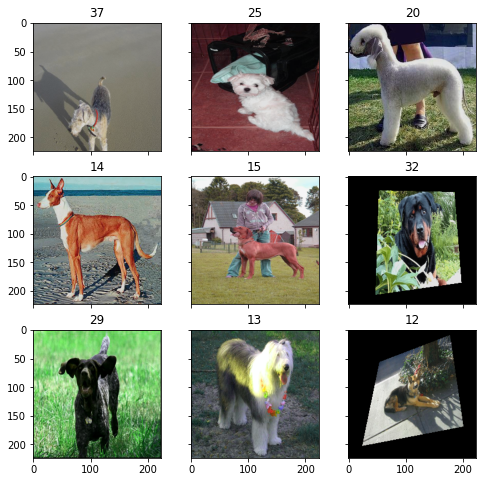

In [202]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
 random_characters = int(np.random.uniform(0,500))
 im_val, label = val_dataset_light_corrupted[random_characters]
 img_label = " ".join(map(lambda x: x.capitalize(),\
 val_dataset_light_corrupted.label_encoder.inverse_transform([label])[0].split('_')))
 imshow(im_val.data.cpu(), \
 title=img_label,plt_ax=fig_x)

In [48]:
test_dataset_not_corrupted = DogsDataset(test_files, mode='test_not_corrupted')

In [20]:
import torchvision
from torchvision import transforms, models

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0
  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data
  return train_loss, train_acc


In [22]:
def eval_epoch(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0
  for inputs, labels in val_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_size += inputs.size(0)
  val_loss = running_loss / processed_size
  val_acc = running_corrects.double() / processed_size
  return val_loss, val_acc

In [23]:
def train(train_files, val_files, model, opt, epochs, batch_size, name):
  train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)
  history = []
  final_acc = 0
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    #opt = torch.optim.AdamW(model.parameters(), lr=0.00005, amsgrad=True)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
      print("loss", train_loss)
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      if val_acc > final_acc:
        torch.save({'model_state_dict': model.state_dict(),}, name)
        final_acc = val_acc
        print("Saved model with val acc", val_acc.item())
      history.append((train_loss, train_acc.item(), val_loss, val_acc.item()))
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

  return history

In [24]:
def predict(model, test_loader):
  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.cuda()
      model.eval()
      outputs = model(inputs).cpu()
      logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [25]:
from sklearn.metrics import f1_score

def final_test(model, name, test_dataset):
    checkpoint = torch.load(name)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    idxs = list(range(len(test_dataset)))
    imgs = [test_dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model.cuda(), imgs)
    actual_labels = [test_dataset[id][1] for id in idxs]
    return f1_score(actual_labels, np.argmax(probs_ims, axis=1), average='micro')

In [26]:
def draw(history, name):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(name)
    plt.show()

In [88]:
# Создаём сеть
model_vgg = models.vgg19(pretrained=True)

In [89]:
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=50, bias=True)

In [90]:
torch.cuda.empty_cache()
name = 'DogsModelVGG19.pth'
opt = torch.optim.AdamW(model_vgg.parameters(), lr=0.00005, amsgrad=True)
history = train(train_dataset_hard_corrupted, val_dataset_hard_corrupted, model= model_vgg.cuda(), opt = opt, epochs=10, batch_size=32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.116025585643767


epoch:  10%|█         | 1/10 [02:09<19:21, 129.02s/it]

Saved model with val acc 0.41148325358851673

Epoch 001 train_loss: 3.1160   val_loss 2.0651 train_acc 0.1939 val_acc 0.4115
loss 1.859135436621305


epoch:  20%|██        | 2/10 [04:17<17:11, 128.89s/it]

Saved model with val acc 0.507177033492823

Epoch 002 train_loss: 1.8591   val_loss 1.7513 train_acc 0.4756 val_acc 0.5072
loss 1.585710746673212


epoch:  30%|███       | 3/10 [06:25<15:01, 128.72s/it]

Saved model with val acc 0.5422647527910686

Epoch 003 train_loss: 1.5857   val_loss 1.5471 train_acc 0.5415 val_acc 0.5423
loss 1.3601404934688976


epoch:  40%|████      | 4/10 [08:34<12:51, 128.60s/it]

Saved model with val acc 0.5502392344497608

Epoch 004 train_loss: 1.3601   val_loss 1.5071 train_acc 0.6081 val_acc 0.5502
loss 1.2768712933728097


epoch:  50%|█████     | 5/10 [10:43<10:43, 128.68s/it]

Saved model with val acc 0.5677830940988836

Epoch 005 train_loss: 1.2769   val_loss 1.4969 train_acc 0.6310 val_acc 0.5678
loss 1.1357646153946548


epoch:  60%|██████    | 6/10 [12:48<08:31, 127.77s/it]


Epoch 006 train_loss: 1.1358   val_loss 1.4745 train_acc 0.6647 val_acc 0.5614
loss 0.9993595895289842


epoch:  70%|███████   | 7/10 [14:56<06:23, 127.81s/it]

Saved model with val acc 0.6108452950558214

Epoch 007 train_loss: 0.9994   val_loss 1.4712 train_acc 0.7030 val_acc 0.6108
loss 0.9783186507482354


epoch:  80%|████████  | 8/10 [17:04<04:15, 127.96s/it]

Saved model with val acc 0.6140350877192983

Epoch 008 train_loss: 0.9783   val_loss 1.3978 train_acc 0.7134 val_acc 0.6140
loss 0.8707267232308566


epoch:  90%|█████████ | 9/10 [19:10<02:07, 127.32s/it]


Epoch 009 train_loss: 0.8707   val_loss 1.5000 train_acc 0.7488 val_acc 0.5917
loss 0.8120993715393796


epoch: 100%|██████████| 10/10 [21:16<00:00, 127.67s/it]


Epoch 010 train_loss: 0.8121   val_loss 1.5606 train_acc 0.7592 val_acc 0.5917


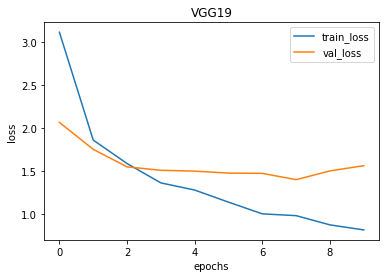

In [91]:
draw(history, "VGG19")

In [92]:
final_test(model_vgg, 'DogsModelVGG19.pth', test_dataset_hard_corrupted)

0.6085836909871245

In [93]:
final_test(model_vgg, 'DogsModelVGG19.pth', test_dataset_medium_corrupted)

0.7081545064377682

In [94]:
final_test(model_vgg, 'DogsModelVGG19.pth', test_dataset_light_corrupted)

0.7922746781115879

In [95]:
final_test(model_vgg, 'DogsModelVGG19.pth', test_dataset_not_corrupted)

0.8197424892703864

In [24]:
model_resnet = models.resnet152(pretrained=True)
model_resnet.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
 nn.Dropout(0.5),
 nn.Linear(1000, 50, bias=True))

In [25]:
torch.cuda.empty_cache()
name = 'DogsModelRESNET152.pth'
opt = torch.optim.AdamW(model_resnet.parameters(), lr=0.00005, amsgrad=True)
history = train(train_dataset_hard_corrupted, val_dataset_hard_corrupted, model=model_resnet.cuda(), opt = opt, epochs=10, batch_size=16, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.8548548959381392


epoch:  10%|█         | 1/10 [02:29<22:21, 149.05s/it]

Saved model with val acc 0.5263157894736842

Epoch 001 train_loss: 2.8549   val_loss 1.7639 train_acc 0.2882 val_acc 0.5263
loss 1.999960834846028


epoch:  20%|██        | 2/10 [04:57<19:50, 148.79s/it]


Epoch 002 train_loss: 2.0000   val_loss 1.8073 train_acc 0.4501 val_acc 0.4896
loss 1.6124990794753602


epoch:  30%|███       | 3/10 [07:26<17:21, 148.80s/it]

Saved model with val acc 0.5629984051036683

Epoch 003 train_loss: 1.6125   val_loss 1.5646 train_acc 0.5478 val_acc 0.5630
loss 1.448477477400907


epoch:  40%|████      | 4/10 [09:54<14:52, 148.72s/it]


Epoch 004 train_loss: 1.4485   val_loss 1.5662 train_acc 0.5852 val_acc 0.5343
loss 1.3264353305911059


epoch:  50%|█████     | 5/10 [12:24<12:24, 148.93s/it]

Saved model with val acc 0.6140350877192983

Epoch 005 train_loss: 1.3264   val_loss 1.3529 train_acc 0.6176 val_acc 0.6140
loss 1.2105247654079017


epoch:  60%|██████    | 6/10 [14:52<09:55, 148.91s/it]


Epoch 006 train_loss: 1.2105   val_loss 1.3744 train_acc 0.6500 val_acc 0.6108
loss 1.1294326039996785


epoch:  70%|███████   | 7/10 [17:22<07:27, 149.03s/it]

Saved model with val acc 0.6523125996810207

Epoch 007 train_loss: 1.1294   val_loss 1.2875 train_acc 0.6719 val_acc 0.6523
loss 1.0751013959434603


epoch:  80%|████████  | 8/10 [19:50<04:57, 148.95s/it]


Epoch 008 train_loss: 1.0751   val_loss 1.3218 train_acc 0.6926 val_acc 0.6188
loss 1.0282041099952595


epoch:  90%|█████████ | 9/10 [22:19<02:28, 148.94s/it]


Epoch 009 train_loss: 1.0282   val_loss 1.2927 train_acc 0.6997 val_acc 0.6300
loss 0.965103505555697


epoch: 100%|██████████| 10/10 [24:49<00:00, 148.91s/it]

Saved model with val acc 0.6698564593301436

Epoch 010 train_loss: 0.9651   val_loss 1.0960 train_acc 0.7132 val_acc 0.6699


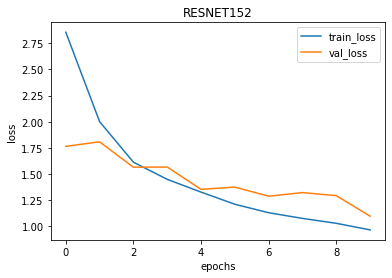

In [28]:
draw(history, "RESNET152")

In [29]:
final_test(model_resnet, 'DogsModelRESNET152.pth', test_dataset_hard_corrupted)

0.6540772532188841

In [33]:
final_test(model_resnet, 'DogsModelRESNET152.pth', test_dataset_medium_corrupted)

0.736480686695279

In [37]:
final_test(model_resnet, 'DogsModelRESNET152.pth', test_dataset_light_corrupted)

0.7974248927038627

In [39]:
final_test(model_resnet, 'DogsModelRESNET152.pth', test_dataset_not_corrupted)

0.8300429184549356

In [31]:
model_densenet = models.densenet161(pretrained=True)

model_densenet.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, 50))

In [32]:
torch.cuda.empty_cache()
name = 'DogsModelDENSENET161.pth'
opt = torch.optim.AdamW(model_densenet.parameters(), lr=0.00005, amsgrad=True)
history = train(train_dataset_hard_corrupted, val_dataset_hard_corrupted, model=model_densenet.cuda(), opt = opt, epochs=10, batch_size=16, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.5800121859808502


epoch:  10%|█         | 1/10 [02:31<22:44, 151.57s/it]

Saved model with val acc 0.38596491228070173

Epoch 001 train_loss: 3.5800   val_loss 2.9576 train_acc 0.1256 val_acc 0.3860
loss 2.2181272426412857


epoch:  20%|██        | 2/10 [05:01<20:08, 151.03s/it]

Saved model with val acc 0.49282296650717705

Epoch 002 train_loss: 2.2181   val_loss 1.7686 train_acc 0.4064 val_acc 0.4928
loss 1.648314621087384


epoch:  30%|███       | 3/10 [07:30<17:33, 150.56s/it]

Saved model with val acc 0.5996810207336524

Epoch 003 train_loss: 1.6483   val_loss 1.4293 train_acc 0.5339 val_acc 0.5997
loss 1.3844244985230847


epoch:  40%|████      | 4/10 [10:00<15:01, 150.31s/it]

Saved model with val acc 0.6108452950558214

Epoch 004 train_loss: 1.3844   val_loss 1.2864 train_acc 0.6053 val_acc 0.6108
loss 1.237875230968065


epoch:  50%|█████     | 5/10 [12:29<12:30, 150.03s/it]

Saved model with val acc 0.6140350877192983

Epoch 005 train_loss: 1.2379   val_loss 1.3218 train_acc 0.6390 val_acc 0.6140
loss 1.1491506484125376


epoch:  60%|██████    | 6/10 [14:59<09:59, 149.82s/it]

Saved model with val acc 0.6507177033492823

Epoch 006 train_loss: 1.1492   val_loss 1.2045 train_acc 0.6643 val_acc 0.6507
loss 1.0416923404893423


epoch:  70%|███████   | 7/10 [17:28<07:28, 149.64s/it]


Epoch 007 train_loss: 1.0417   val_loss 1.2989 train_acc 0.6950 val_acc 0.6411
loss 0.9919117584208995


epoch:  80%|████████  | 8/10 [19:57<04:58, 149.36s/it]


Epoch 008 train_loss: 0.9919   val_loss 1.2653 train_acc 0.7077 val_acc 0.6396
loss 0.9431221811000325


epoch:  90%|█████████ | 9/10 [22:25<02:29, 149.15s/it]


Epoch 009 train_loss: 0.9431   val_loss 1.2483 train_acc 0.7173 val_acc 0.6427
loss 0.8770383447131394


epoch: 100%|██████████| 10/10 [24:54<00:00, 149.44s/it]

Saved model with val acc 0.6921850079744817

Epoch 010 train_loss: 0.8770   val_loss 1.0720 train_acc 0.7471 val_acc 0.6922


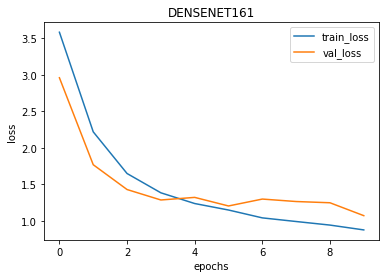

In [33]:
draw(history, "DENSENET161")

In [34]:
final_test(model_densenet, 'DogsModelDENSENET161.pth', test_dataset_hard_corrupted)

0.6609442060085837

In [35]:
final_test(model_densenet, 'DogsModelDENSENET161.pth', test_dataset_medium_corrupted)

0.751931330472103

In [36]:
final_test(model_densenet, 'DogsModelDENSENET161.pth', test_dataset_light_corrupted)

0.8077253218884121

In [37]:
final_test(model_densenet, 'DogsModelDENSENET161.pth', test_dataset_not_corrupted)

0.8480686695278971

In [39]:
model_resnet50 = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/pekudrjavtseva/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [41]:
model_resnet50.fc = nn.Linear(in_features=2048, out_features=50, bias=True)

In [42]:
torch.cuda.empty_cache()
name = 'DogsModelResnet50.pth'
opt = torch.optim.AdamW(model_resnet50.parameters(), lr=0.00005, amsgrad=True)
history = train(train_dataset_hard_corrupted, val_dataset_hard_corrupted, model=model_resnet50.cuda(), opt = opt, epochs=10, batch_size=32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.0525322230189627


epoch:  10%|█         | 1/10 [01:49<16:21, 109.11s/it]

Saved model with val acc 0.5135566188197768

Epoch 001 train_loss: 3.0525   val_loss 2.0698 train_acc 0.2823 val_acc 0.5136
loss 1.9172193243639328


epoch:  20%|██        | 2/10 [03:35<14:26, 108.27s/it]


Epoch 002 train_loss: 1.9172   val_loss 1.7764 train_acc 0.4658 val_acc 0.4817
loss 1.492965955693437


epoch:  30%|███       | 3/10 [05:20<12:31, 107.37s/it]

Saved model with val acc 0.5964912280701754

Epoch 003 train_loss: 1.4930   val_loss 1.4559 train_acc 0.5655 val_acc 0.5965
loss 1.3442563941188581


epoch:  40%|████      | 4/10 [07:06<10:40, 106.79s/it]


Epoch 004 train_loss: 1.3443   val_loss 1.4283 train_acc 0.6185 val_acc 0.5885
loss 1.1982588531095208


epoch:  50%|█████     | 5/10 [08:53<08:54, 106.97s/it]


Epoch 005 train_loss: 1.1983   val_loss 1.4717 train_acc 0.6494 val_acc 0.5853
loss 1.1615855220440465


epoch:  60%|██████    | 6/10 [10:40<07:08, 107.12s/it]

Saved model with val acc 0.6555023923444976

Epoch 006 train_loss: 1.1616   val_loss 1.2533 train_acc 0.6630 val_acc 0.6555
loss 1.1235042396069106


epoch:  70%|███████   | 7/10 [12:28<05:21, 107.19s/it]


Epoch 007 train_loss: 1.1235   val_loss 1.2468 train_acc 0.6691 val_acc 0.6364
loss 1.0775113235542133


epoch:  80%|████████  | 8/10 [14:14<03:33, 106.86s/it]


Epoch 008 train_loss: 1.0775   val_loss 1.2372 train_acc 0.6865 val_acc 0.6443
loss 0.9849071112049971


epoch:  90%|█████████ | 9/10 [15:59<01:46, 106.30s/it]


Epoch 009 train_loss: 0.9849   val_loss 1.2695 train_acc 0.7080 val_acc 0.6380
loss 0.9649619131137945


epoch: 100%|██████████| 10/10 [17:44<00:00, 106.47s/it]


Epoch 010 train_loss: 0.9650   val_loss 1.3228 train_acc 0.7170 val_acc 0.6300


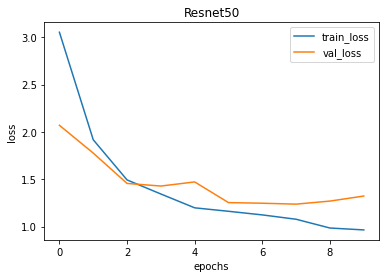

In [43]:
draw(history, "Resnet50")

In [45]:
final_test(model_resnet50, 'DogsModelResnet50.pth', test_dataset_hard_corrupted)

0.6137339055793991

In [46]:
final_test(model_resnet50, 'DogsModelResnet50.pth', test_dataset_medium_corrupted)

0.7399141630901288

In [47]:
final_test(model_resnet50, 'DogsModelResnet50.pth', test_dataset_light_corrupted)

0.7991416309012876

In [49]:
final_test(model_resnet50, 'DogsModelResnet50.pth', test_dataset_not_corrupted)

NameError: name 'model_resnet50' is not defined

In [36]:
model_shuffle = models.wide_resnet50_2(pretrained=True)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /home/pekudrjavtseva/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


In [38]:
model_shuffle.fc = nn.Linear(model_shuffle.fc.in_features, 50)

In [39]:
torch.cuda.empty_cache()
name = 'DogsModelShuffle.pth'
opt = torch.optim.AdamW(model_shuffle.parameters(), lr=0.00005, amsgrad=True)
history = train(train_dataset_hard_corrupted, val_dataset_hard_corrupted, model=model_shuffle.cuda(), opt = opt, epochs=10, batch_size=32, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.9222139304661154


epoch:  10%|█         | 1/10 [02:14<20:13, 134.87s/it]

Saved model with val acc 0.5661881977671451

Epoch 001 train_loss: 2.9222   val_loss 1.8293 train_acc 0.3439 val_acc 0.5662
loss 1.7760332138688315


epoch:  20%|██        | 2/10 [04:26<17:52, 134.02s/it]

Saved model with val acc 0.569377990430622

Epoch 002 train_loss: 1.7760   val_loss 1.5625 train_acc 0.5084 val_acc 0.5694
loss 1.3720786202827882


epoch:  30%|███       | 3/10 [07:19<16:58, 145.45s/it]

Saved model with val acc 0.6044657097288676

Epoch 003 train_loss: 1.3721   val_loss 1.4264 train_acc 0.6064 val_acc 0.6045
loss 1.1860482063619986


epoch:  40%|████      | 4/10 [10:12<15:22, 153.81s/it]


Epoch 004 train_loss: 1.1860   val_loss 1.4496 train_acc 0.6535 val_acc 0.5758
loss 1.1011666979295505


epoch:  50%|█████     | 5/10 [13:33<14:00, 168.06s/it]

Saved model with val acc 0.6762360446570973

Epoch 005 train_loss: 1.1012   val_loss 1.1574 train_acc 0.6786 val_acc 0.6762
loss 0.9807772123108223


epoch:  60%|██████    | 6/10 [15:44<10:27, 156.92s/it]


Epoch 006 train_loss: 0.9808   val_loss 1.1792 train_acc 0.7121 val_acc 0.6619
loss 0.9409368083873645


epoch:  70%|███████   | 7/10 [17:54<07:26, 148.75s/it]


Epoch 007 train_loss: 0.9409   val_loss 1.2353 train_acc 0.7242 val_acc 0.6364
loss 0.8860653988659315


epoch:  80%|████████  | 8/10 [20:04<04:46, 143.12s/it]


Epoch 008 train_loss: 0.8861   val_loss 1.1845 train_acc 0.7440 val_acc 0.6667
loss 0.8024011783587431


epoch:  90%|█████████ | 9/10 [22:12<02:18, 138.65s/it]


Epoch 009 train_loss: 0.8024   val_loss 1.1769 train_acc 0.7665 val_acc 0.6699
loss 0.7691389153693128


epoch: 100%|██████████| 10/10 [24:22<00:00, 146.24s/it]


Epoch 010 train_loss: 0.7691   val_loss 1.1785 train_acc 0.7711 val_acc 0.6507


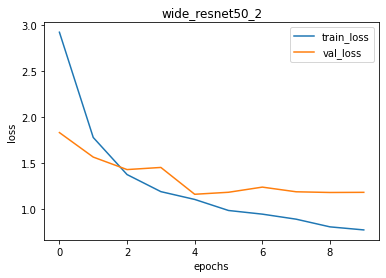

In [40]:
draw(history, "wide_resnet50_2")

In [42]:
final_test(model_shuffle, 'DogsModelShuffle.pth', test_dataset_hard_corrupted)

0.6420600858369099

In [43]:
final_test(model_shuffle, 'DogsModelShuffle.pth', test_dataset_medium_corrupted)

0.742489270386266

In [50]:
final_test(model_shuffle, 'DogsModelShuffle.pth', test_dataset_light_corrupted)

0.8360515021459227

In [51]:
final_test(model_shuffle, 'DogsModelShuffle.pth', test_dataset_not_corrupted)

0.8592274678111588

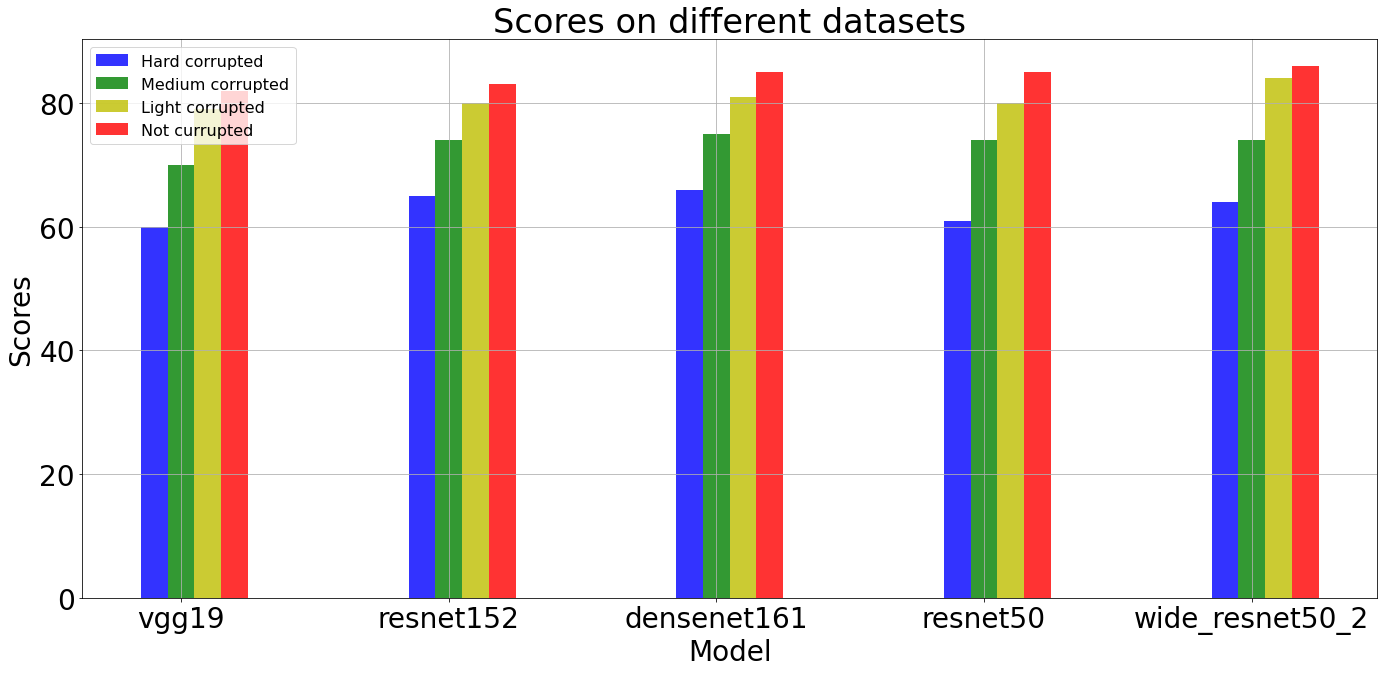

In [123]:
scores_hard = (60, 65, 66, 61, 64)
scores_medium = (70, 74, 75, 74, 74)
scores_light = (79, 80, 81, 80, 84)
scores_not = (82, 83, 85, 85, 86)

# create plot
fig, ax = plt.subplots()
index = np.arange(len(means_frank))
bar_width = 0.1
opacity = 0.8

ax.grid()

rects1 = plt.bar(index, scores_hard, bar_width,
alpha=opacity,
color='b',
label='Hard corrupted')

rects2 = plt.bar(index + bar_width, scores_medium, bar_width,
alpha=opacity,
color='g',
label='Medium corrupted')

rects3 = plt.bar(index + 2*bar_width, scores_light, bar_width,
alpha=opacity,
color='y',
label='Light corrupted')

rects4 = plt.bar(index + 3*bar_width, scores_not, bar_width,
alpha=opacity,
color='r',
label='Not currupted')

fig.set_size_inches((20,10))

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Scores on different datasets')
plt.xticks(index + bar_width, ('vgg19', 'resnet152', 'densenet161', 'resnet50', 'wide_resnet50_2'))
plt.legend(loc = 'best', fontsize = 16)

plt.tight_layout()
plt.rcParams.update({'font.size': 28})
plt.show()

In [124]:
model = models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=50, bias=True)

In [125]:
checkpoint = torch.load('DogsModelVGG19.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [190]:
import pandas as pd

def accuracy_by_class(model, test_dataset):
    idxs = list(range(len(test_dataset_not_corrupted)))
    imgs = [test_dataset_not_corrupted[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model.cuda(), imgs)
    actual_labels = [test_dataset_not_corrupted[id][1] for id in idxs]
    
    df = pd.DataFrame()
    df["True"] = actual_labels
    df["Pred"] = np.argmax(probs_ims, axis=1)
    df["Result"] = df["True"]==df["Pred"]
    
    results = df.groupby("True", as_index = False).agg({"Pred" : "count",
                                        "Result" : "sum"})
    results["Persent"] = round((results["Result"] / results["Pred"]) * 100, 2)
    return results.sort_values(by = ['Persent'], ascending=False)

In [186]:
accuracy_by_class(model, test_dataset_not_corrupted, probs_ims, actual_labels)

,True,Pred,Result,Persent
38,38,25,25.0,100.00
4,4,20,20.0,100.00
29,29,32,32.0,100.00
36,36,21,21.0,100.00
9,9,23,23.0,100.00
32,32,29,28.0,96.55
34,34,23,22.0,95.65
3,3,23,22.0,95.65
40,40,21,20.0,95.24
43,43,20,19.0,95.00


In [187]:
model_resnet = models.resnet152(pretrained=True)
model_resnet.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
 nn.Dropout(0.5),
 nn.Linear(1000, 50, bias=True))

In [189]:
checkpoint = torch.load('DogsModelRESNET152.pth')
model_resnet.load_state_dict(checkpoint['model_state_dict'])
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [192]:
accuracy_by_class(model_resnet, test_dataset_not_corrupted)

,True,Pred,Result,Persent
29,29,32,32.0,100.00
32,32,29,29.0,100.00
13,13,24,24.0,100.00
34,34,23,22.0,95.65
14,14,21,20.0,95.24
36,36,21,20.0,95.24
40,40,21,20.0,95.24
12,12,21,20.0,95.24
20,20,20,19.0,95.00
4,4,20,19.0,95.00


In [193]:
model_densenet = models.densenet161(pretrained=True)

model_densenet.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, 50))

checkpoint = torch.load('DogsModelDENSENET161.pth')
model_densenet.load_state_dict(checkpoint['model_state_dict'])
model_densenet.eval()

accuracy_by_class(model_densenet, test_dataset_not_corrupted)

,True,Pred,Result,Persent
36,36,21,21.0,100.00
17,17,22,22.0,100.00
38,38,25,25.0,100.00
32,32,29,29.0,100.00
28,28,20,20.0,100.00
27,27,20,20.0,100.00
1,1,20,20.0,100.00
48,48,29,29.0,100.00
0,0,25,24.0,96.00
13,13,24,23.0,95.83


In [194]:
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(in_features=2048, out_features=50, bias=True)

checkpoint = torch.load('DogsModelResnet50.pth')
model_resnet50.load_state_dict(checkpoint['model_state_dict'])
model_resnet50.eval()

accuracy_by_class(model_resnet50, test_dataset_not_corrupted)

,True,Pred,Result,Persent
14,14,21,21.0,100.00
48,48,29,29.0,100.00
22,22,19,19.0,100.00
27,27,20,20.0,100.00
36,36,21,21.0,100.00
32,32,29,28.0,96.55
35,35,27,26.0,96.30
38,38,25,24.0,96.00
3,3,23,22.0,95.65
40,40,21,20.0,95.24


In [196]:
model_shuffle = models.wide_resnet50_2(pretrained=True)
model_shuffle.fc = nn.Linear(model_shuffle.fc.in_features, 50)

checkpoint = torch.load('DogsModelShuffle.pth')
model_shuffle.load_state_dict(checkpoint['model_state_dict'])
model_shuffle.eval()

accuracy_by_class(model_shuffle, test_dataset_not_corrupted)

,True,Pred,Result,Persent
40,40,21,21.0,100.00
14,14,21,21.0,100.00
35,35,27,27.0,100.00
30,30,27,27.0,100.00
29,29,32,32.0,100.00
27,27,20,20.0,100.00
1,1,20,20.0,100.00
17,17,22,22.0,100.00
32,32,29,29.0,100.00
48,48,29,29.0,100.00
